In [1]:
## imports
import numpy as np
import pandas as pd
import pycwt as cwt
import scipy
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
from utils import (nearest, butter_bandpass_filter, nearesttime,
                   nearestvalue, drop, lead_sz, circ_add, circ_uniformity, rayleigh)

In [2]:
## open data
heart_rate = pd.read_pickle("sample_data/heart_rate.pickle")
print(heart_rate.head())

# convert timestamps to datetime
heart_rate['timestamp'] = heart_rate.timestamp.astype("datetime64[ms]") # utc
heart_rate = heart_rate[heart_rate['timestamp'] <= datetime(2021, 1, 1)]

print(heart_rate.head())
print(heart_rate['timestamp'].iloc[0], heart_rate['timestamp'].iloc[-1])

      timestamp  value
0  1.570849e+12   70.0
1  1.570849e+12   73.0
2  1.570849e+12   78.0
3  1.570849e+12   75.0
4  1.570849e+12   74.0
            timestamp  value
0 2019-10-12 03:02:49   70.0
1 2019-10-12 03:02:59   73.0
2 2019-10-12 03:03:04   78.0
3 2019-10-12 03:03:09   75.0
4 2019-10-12 03:03:19   74.0
2019-10-12 03:02:49 2020-12-31 23:59:53


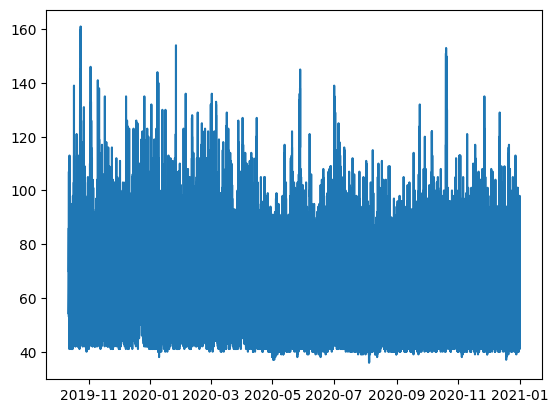

In [3]:
plt.plot(heart_rate['timestamp'][heart_rate['timestamp'] <= datetime(2021, 1, 1)], heart_rate['value'][heart_rate['timestamp'] <= datetime(2021, 1, 1)])
plt.show()

In [4]:
# variables                
WAVELET = cwt.Morlet(6)
ORDER = 2
FS=60

In [5]:
# prepare data for wavelet analysis
heart_rate = heart_rate.resample('1Min', on='timestamp').mean().reset_index()
# heart_rate['value'] = (heart_rate['value'] - heart_rate['value'].mean())/heart_rate['value'].std() #standardization
heart_rate['value'][pd.isnull(heart_rate['value'])] = heart_rate['value'].mean() # interpolation

# custom frequencies with maximum scale n (where n is 1/4 the length of the data) - i.e. we need to observe 4 cycles
n = (heart_rate['timestamp'].iloc[-1] - heart_rate['timestamp'].iloc[0]).total_seconds()/3600/4
periods = np.append(np.arange(2.4, 31.2, 1.2), np.arange(31.2, 48, 2.4))
periods = np.append(periods, np.arange(2.2*24, 4*24 + 4.8, 4.8))
periods = np.append(periods, np.arange(5*24, int(n), 12))
freqs = (1/periods)

# wavelet signal
y = heart_rate.resample('5Min', on='timestamp').mean().reset_index().value.to_numpy()

/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_29482/66476678.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  heart_rate['value'][pd.isnull(heart_rate['value'])] = heart_rate['value'].mean() # interpolation
/var/folders/32/fw

In [6]:
# wavelet analysis
dt = 1/12
alpha, _, _ = cwt.ar1(y) # lag 1 autocorrelation for significance (alpha = np.corrcoef(y[:-1], y[1:])[0, 1])
wave, scales, freqs, coi, fft, fftfreqs = cwt.cwt(signal = y, dt = dt, wavelet = WAVELET, freqs = freqs)
power = np.abs(wave) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs
glbl_power = power.mean(axis=1)
dof = y.size - scales  # Correction for padding at edges
var = y.std()**2
glbl_signif, tmp = cwt.significance(var, dt, scales, 1, alpha, significance_level=0.99, dof=dof, wavelet=WAVELET)
signif, fft_theor = cwt.significance(1.0, dt, scales, 0, alpha, significance_level=0.99, wavelet=WAVELET)

In [7]:
# peak analysis
# Find peaks that are significant
xpeaks = []; powers = []
ind_peaks = scipy.signal.find_peaks(var * glbl_power)[0]
for i in ind_peaks:
    peak = [var * glbl_power > glbl_signif][0][i]
    if peak:
        if period[i] not in xpeaks:
            xpeaks.append(period[i])
            powers.append([var * glbl_power][0][i])

# keep only stongest peak if there is a peak within +/- 33% of another peak
xpeaks = np.array(xpeaks)  
new_xpeaks = {}
for peak in xpeaks:
    ints2 = np.where(np.logical_and(xpeaks>=peak-0.33*peak, xpeaks<=peak+0.33*peak))
    # is the peak in another peaks BP filter?
    other = [i for i,p in enumerate(xpeaks) if peak >= p - 0.33*p and peak <= p + 0.33*p]
    ints2 = set(np.array(list(ints2[0]) + other))
    if len(ints2):
        # if there is a peak within +/- 33%, check the power of it, choose highest
        max_peak = xpeaks[[var * glbl_power][0].tolist().index(np.max([[var * glbl_power][0][i] for i in ints2]))]
        new_xpeaks[peak] = max_peak
xpeaks = sorted(set(new_xpeaks.values()))

print([x/24 for x in xpeaks])

[0.49999999999999994, 0.9999999999999997, 5.5, 9.5, 30.5, 51.5]


/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_29482/3414644105.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  wavelet_data['peak'][wavelet_data.period == nearest(wavelet_data.period, peak)] = 1
/var/folders/32/fw5qd6c92fd3q

   period         power          sig  peak
0     2.4  18047.039067   400.744080   0.0
1     3.6  33947.854062   802.346276   0.0
2     4.8  51923.333214  1234.516732   0.0
3     6.0  75790.860729  1644.119791   0.0
4     7.2  93769.565604  2006.251027   0.0


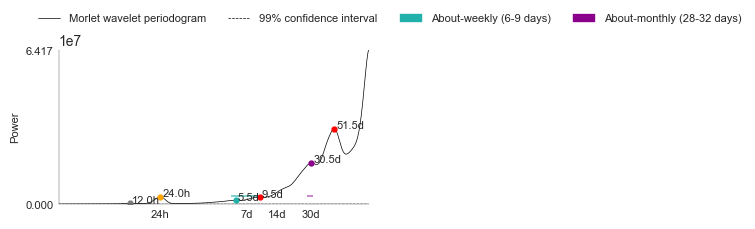

In [9]:
# store wavelet data
wavelet_data = pd.DataFrame()
wavelet_data['period'] = period
wavelet_data['power'] = var * glbl_power
wavelet_data['sig'] = glbl_signif
wavelet_data['peak'] = np.zeros(len(wavelet_data))
for peak in xpeaks:
    wavelet_data['peak'][wavelet_data.period == nearest(wavelet_data.period, peak)] = 1

print(wavelet_data.head())

# Find peaks that are significant
ypeaks = []; peaknames = []
for peak in xpeaks:
    ypeaks.append(wavelet_data.power[wavelet_data.period == peak].to_list()[0])
    if peak < 96:
        peaknames.append(str(round(peak,2)) + 'h')
    else:
        peaknames.append(str(round(peak/24,2)) + 'd')

# PLOT CONSTANTS
graph_size = (4, 2)
font_size_tick = 8      # axis ticks / labels
marker_sz = 3.5
arrow_sz = 6
hr_buffer = 0.1
ax_lw = 0.25
plot_lw = 0.5

# Plot original vs reconstructed wavelet on top subplot and wavelet power spectrum with sig peaks on second subplot
plt.style.use("seaborn-v0_8-white")
plt.figure(figsize=graph_size)
plt.plot(wavelet_data.period, wavelet_data.power, 'k-', linewidth=plot_lw, label = 'Morlet wavelet periodogram')
plt.plot(wavelet_data.period, wavelet_data.sig, 'k--', label = '99% confidence interval', linewidth=plot_lw)
plt.xlim([np.min(wavelet_data.period), np.max(wavelet_data.period)])
plt.ylim(0,np.max(wavelet_data.power) + 50)
plt.xscale('log')
plt.xticks([24,7*24,14*24, 30*24], ['24h', '7d', '14d', '30d'], fontsize=font_size_tick)
plt.yticks([0,round(np.max(wavelet_data.power)/10)*10], fontsize=font_size_tick)
plt.ylabel("Power", fontsize = font_size_tick)
if len(xpeaks) != 0:
    for a,b,c in zip(xpeaks, ypeaks, peaknames):
        if round(a) == 24:
            plt.plot(a, b,'orange', marker = 'o', linestyle = '', markersize = marker_sz)
            plt.text(a + a*0.05, b + b*0.02, c, fontsize = font_size_tick)
        elif a>=5*24 and a<=9*24:
            plt.plot(a, b,'lightseagreen', marker = 'o', linestyle = '', markersize = marker_sz)
            plt.text(a + a*0.05, b + b*0.02, c, fontsize = font_size_tick)
            plt.arrow(5*24,np.max(wavelet_data.power)*0.05,4*24,0,head_length = 10, length_includes_head=True, head_width = arrow_sz, linewidth=ax_lw, color='lightseagreen', label = 'About-weekly (6-9 days)')
            plt.arrow(9*24,np.max(wavelet_data.power)*0.05,-4*24,0,head_length = 6, length_includes_head=True, head_width = arrow_sz, linewidth=ax_lw, color = 'lightseagreen')
        elif a>=28*24 and a<=32*24:
            plt.plot(a, b,'darkmagenta', marker = 'o', linestyle = '', markersize = marker_sz)
            plt.text(a + a*0.05, b + b*0.01, c, fontsize = font_size_tick)
            plt.arrow(28*24,np.max(wavelet_data.power)*0.05,4*24,0,head_length = 10, length_includes_head=True, head_width = arrow_sz, linewidth=ax_lw, color='darkmagenta', label = 'About-monthly (28-32 days)')
            plt.arrow(32*24,np.max(wavelet_data.power)*0.05,-4*24,0,head_length = 6, length_includes_head=True, head_width = arrow_sz, linewidth=ax_lw, color = 'darkmagenta')
        else:
            if a>24:
                plt.plot(a, b,'red', marker = 'o', linestyle = '', markersize = marker_sz)
                plt.text(a + a*0.05, b + b*0.01, c, fontsize = font_size_tick)
            else:
                plt.plot(a, b,'gray', marker = 'o', linestyle = '', markersize = marker_sz)
                plt.text(a + a*0.05, b + b*0.01, c, fontsize = font_size_tick)
plt.legend(fontsize=font_size_tick, loc='upper left', bbox_to_anchor=(-.1,1.3), ncol=4)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), linewidth=ax_lw)

plt.savefig('plots/tutorial_wavelet.png', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
# heart rate cycle types
heart_rate_cycles = {}
for f in xpeaks:
    if round(f) == 24:
        peak_type = 'circadian'
    elif f >=(5*24) and f <=(9*24):
        peak_type = 'weekly'
    elif f >=(28*24) and f <=(32*24):
        peak_type = 'monthly'
    else:
        if f<16:
            peak_type = 'ultradian'
        else:
            peak_type = 'multiday'
    heart_rate_cycles[f] = peak_type

print(heart_rate_cycles)

{11.999999999999998: 'ultradian', 23.999999999999993: 'circadian', 132.0: 'weekly', 228.0: 'multiday', 732.0: 'monthly', 1236.0: 'multiday'}


In [11]:
filtered = pd.DataFrame()
filtered['timestamp'] = heart_rate['timestamp']

for f in xpeaks:
    lowcut = 1/(f + (1/3)*f)
    highcut = 1/(f - (1/3)*f)

    # Create a new dataframe to store the filtered data around that frequency, and then corresponding phases and seizures
    filtered_data = butter_bandpass_filter(heart_rate['value'], lowcut, highcut, FS, order=ORDER)
    hilb_phases = np.angle(scipy.signal.hilbert(filtered_data)) + np.pi
    analytic_signal = scipy.signal.hilbert(filtered_data)
    amplitude_envelope = np.real(analytic_signal)
    filtered[str(f) + '_value'] = filtered_data
    filtered[str(f) + '_phase'] = hilb_phases
    filtered[str(f) + '_amp'] = amplitude_envelope

filtered = filtered.resample('1H', on='timestamp', label='right').mean().reset_index()

## plot filtered cycles


/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_29482/4148750974.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  filtered = filtered.resample('1H', on='timestamp', label='right').mean().reset_index()


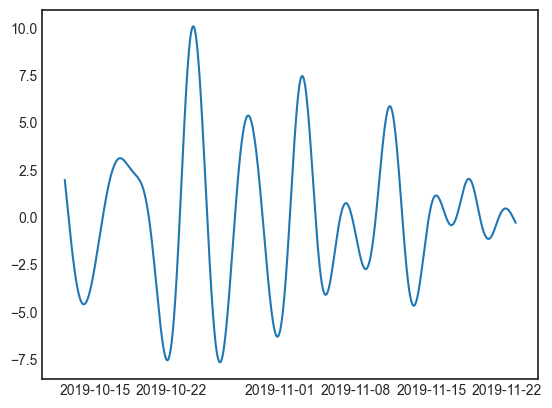

In [17]:
plt.plot(filtered['timestamp'][:1000], filtered['132.0_value'][:1000])
plt.show()

In [18]:
# PLOT CONSTANTS
graph_size = (4,1.8)
hist_size = (1.6,1.6)
font_size_tick = 8
marker_sz = 3.5
hr_buffer = 0.1
ax_lw = 0.25
plot_lw = 0.5

# Prepare data and apply moving averages
slow = heart_rate.resample('1H', label = 'right', on = 'timestamp').mean().reset_index()
monthly = slow.copy()
heart_rate['MA'] = heart_rate['value'].rolling(60, min_periods = 5).mean()
slow['value'] = slow['value'].rolling(48, min_periods = 16).mean()
monthly['value'] = monthly['value'].rolling(7*24, min_periods = 5*24).mean()

# find first and last time of fornightly fast plot
first_time = (heart_rate['timestamp'].iloc[-1] - heart_rate['timestamp'].iloc[0])/2 + heart_rate['timestamp'].iloc[0]
last_time = first_time + timedelta(days=14)
while drop(heart_rate, first_time, last_time).isnull().value.any():
    first_time += timedelta(days=1)
    last_time += timedelta(days=1)

/var/folders/32/fw5qd6c92fd3qjj852lnn9tw0000gn/T/ipykernel_29482/3300650869.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  slow = heart_rate.resample('1H', label = 'right', on = 'timestamp').mean().reset_index()


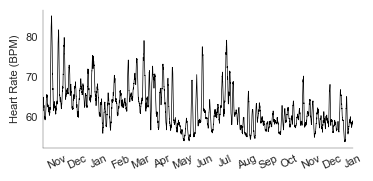

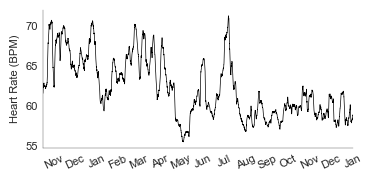

In [20]:
'''START PLOTTING'''
for dataset, sfilter in zip([slow, monthly], ['2-day', '7-day']):
        
    plt.style.use("seaborn-v0_8-white")
    fig = plt.figure(figsize=graph_size)
    plt.plot(dataset['timestamp'], dataset['value'], 'black', linewidth=plot_lw, label = '{} smoothed heart rate'.format(sfilter))
    plt.ylabel('Heart Rate (BPM)', fontsize=font_size_tick)
    plt.yticks(fontsize=font_size_tick)
    plt.xticks(rotation=25, fontsize=font_size_tick)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.spines.values(), linewidth=ax_lw)
    monthyearFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(monthyearFmt)

    plt.xlim([dataset.dropna()['timestamp'].iloc[0],dataset.dropna()['timestamp'].iloc[-1]])
    start, end = ax.get_ylim()
    plt.savefig(f'plots/hr_{colour[:3]}_{sfilter}_tutorial.png', bbox_inches='tight', dpi=300)
    plt.show()

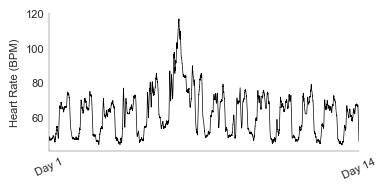

In [21]:
# plot the fast heart rate
fig = plt.figure(figsize=graph_size)
plt.plot(drop(heart_rate, first_time, last_time)['timestamp'], drop(heart_rate, first_time, last_time)['MA'], 'black',
            linewidth=plot_lw, label = '1-hour smoothed heart rate')
plt.ylabel('Heart Rate (BPM)', fontsize=font_size_tick)
plt.yticks(fontsize=font_size_tick)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.spines.values(), linewidth=ax_lw)
plt.xlim([first_time,last_time])
start, end = ax.get_ylim()
startx, endx = ax.get_xlim()
plt.xticks([startx,endx],['Day 1', 'Day 14'], rotation=25, fontsize=font_size_tick)
plt.savefig('plots/hr_inset_tutorial.png', bbox_inches='tight', dpi=300)
plt.show()